In [1]:
import MEArec as mr
import numpy as np
import matplotlib.pyplot as plt
import MEAutility as mu
import LFPy
from matplotlib.collections import LineCollection
from neuron import h
import os
import inspect
from pathlib import Path
import shutil
import plotly
import h5py
import pickle

In [2]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [3]:
# Load templates file and match predicted template from recording to actual template
# Figure out which cell generated the template and what the position and location were
# Transpose cell on top of template to see how they align
# Generate reconstruction and transpose on top of cell to see alignment
# Do this for all cells and show how they can all be transposed on top of one another

In [4]:
# Load template file 
filename = './ziad_mearec_templates/mag_templates_2-4cells_n50_100MEA75.h5'
temp_dict = {}
with h5py.File(filename, "r") as f:
    # List all groups
    for key in f.keys():
        temp_dict[key] = np.array(f[key])
        
# Load custom MEA file
mea_name = '100MEA75'
mu.add_mea(mea_name + '.yaml')
custom_mea = mu.return_mea(mea_name)

# Generate template from saved data
template_params = mr.get_default_templates_params()
template_params['n'] = 50 # Number of random positions the cell is simulated in
template_params['probe'] = '100MEA75' # Electrode array configuration (7x7 with 20um pitch)

info = {}
info['params'] = template_params
info['electrodes'] = mu.return_mea_info(template_params['probe'])

tempgen = mr.TemplateGenerator(temp_dict = temp_dict, info=info)

['100MEA75', 'Neuronexus-32', 'Neuropixels-128', 'Neuropixels-24', 'Neuropixels-384', 'Neuropixels-64', 'Neuroseeker-128', 'SqMEA-10-15', 'SqMEA-15-10', 'SqMEA-5-30', 'SqMEA-6-25', 'SqMEA-7-20', 'monotrode', 'tetrode', 'tetrode-mea-d', 'tetrode-mea-l', 'tetrode-mea-s']


<AxesSubplot:>

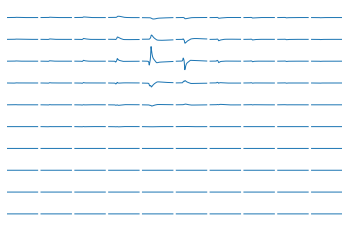

In [11]:
temp_id = 1
# mr.plot_templates(tempgen, template_ids = temp_id, magnetic = False, dim = 0)
# mr.plot_templates(tempgen, template_ids = temp_id, magnetic = True, dim = 0)
# mr.plot_templates(tempgen, template_ids = temp_id, magnetic = True, dim = 1)
mr.plot_templates(tempgen, template_ids = temp_id, magnetic = True, dim = 0)

In [19]:
# Load templates from sorting
with open ("Templates_Mag_20Cells_20s_Noise5.pickle", "rb") as f:
    sort_data = pickle.load(f)

sort_temps = sort_data['templates']
print("Mags shape: ", np.shape(tempgen.mags))
dim = 2
orig_temps = tempgen.mags[:, :, dim, :]

print("Sorted templates shape: ", np.shape(sort_temps))
print("Original templates shape: ", np.shape(orig_temps))

# Normalize temps
sort_temps = sort_temps / np.max(abs(sort_temps))
orig_temps = orig_temps / np.max(abs(orig_temps))

orig_tempgen = mr.TemplateGenerator(temp_dict = temp_dict, info=info)
orig_tempgen.templates = orig_temps
sort_tempgen = mr.TemplateGenerator(temp_dict = temp_dict, info=info)
sort_tempgen.templates = np.einsum('abc->acb', sort_temps)

Mags shape:  (100, 100, 3, 224)
Sorted templates shape:  (20, 224, 100)
Original templates shape:  (100, 100, 224)


In [20]:
# Get 3 largest signals for a template
def get_largest_temps(temps, count):
    # Get maximum value at each sensor
    maxvals = np.max(abs(temps), axis=1)
    #print("Num of maxvals: ", len(maxvals))
    
    # Sort max values by sensor index
    maxargs = list(np.argsort(maxvals))
    maxargs.reverse()
    
    # Get templates of n largest signals
    sigs = temps[maxargs[0:count]]
    #print("Largest signals shape: ", np.shape(sigs))
    
    return sigs, maxargs[0:count]

# Convolve signals to see which has greatest match
def compare_temps(temps1, temps2):
    all_convs = []
    for i in range(len(temps1)):
        for j in range(len(temps2)):
            convolve_peak = np.max(np.convolve(temps1[i], temps2[j]))
            all_convs.append(convolve_peak)
    
    return all_convs

In [21]:
# Print which templates match most closely based on which have matching peak sensors

for i in range(len(sort_temps)):
    sigs, sort_maxargs = get_largest_temps(sort_temps[i].T, 3)
    #print("Sort: ", sort_maxargs)
    #print()
    for j in range(len(orig_temps)):
        sigs, orig_maxargs = get_largest_temps(orig_temps[j], 3)
        if sort_maxargs == orig_maxargs:
            print("Found identical: ", i, j)
            #print()
        elif set(sort_maxargs) == set(orig_maxargs):
            print("Found extremely close: ", i, j)
            #print()
        elif bool(set(sort_maxargs) & set(orig_maxargs)):
            #print(j)
            #print(orig_maxargs)
            #print()
            pass

Found identical:  0 2
Found extremely close:  1 27
Found extremely close:  2 6
Found identical:  3 14
Found identical:  5 96
Found identical:  6 81
Found extremely close:  7 4
Found extremely close:  8 42
Found identical:  8 97
Found extremely close:  9 0
Found identical:  10 15
Found extremely close:  12 9
Found identical:  12 23
Found identical:  13 8
Found identical:  13 45
Found identical:  14 59
Found extremely close:  15 3
Found identical:  15 29
Found extremely close:  15 61
Found extremely close:  16 38
Found identical:  17 58
Found extremely close:  18 98
Found extremely close:  19 22
Found identical:  19 36
Found extremely close:  19 57


<AxesSubplot:>

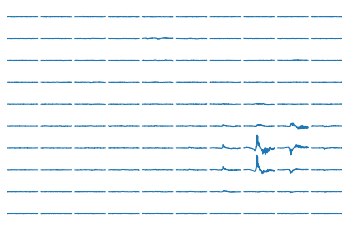

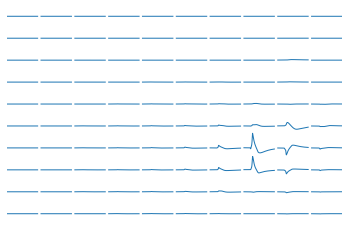

In [23]:
template_id = 0
mr.plot_templates(sort_tempgen, template_ids = 1)
mr.plot_templates(orig_tempgen, template_ids = 27)

In [180]:
np.shape(tempgen.locations)

(100, 3)

Cell Model:  /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/L5_TTPC1_cADpyr232_1
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Real morph


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_75668/4222424366.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax1.plot(electrodes.y, electrodes.z, '.', marker='o', markersize=3, color='k', zorder=0)


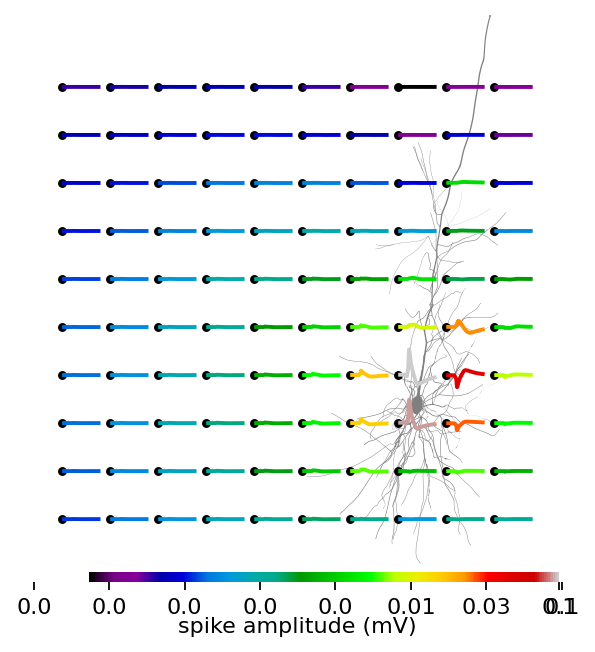

In [29]:
# Plot cell on top of recording

# Get x-axis data (out-of-plane field for YZ electrodes)
dim = 2
orig_temps = tempgen.mags[:, :, dim, :]
orig_temps = orig_temps / np.max(abs(orig_temps))
orig_tempgen = mr.TemplateGenerator(temp_dict = temp_dict, info=info)
orig_tempgen.templates = orig_temps

# Index in orig_temps corresponding to specified template in sort_temps
sort_temp_id = 1
orig_temp_id = 27

template_id = orig_temp_id

# Get index of cell within list of all cells from template_id
startcells = 2
cell_model_id = int(np.floor(template_id / 50)) + startcells

mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
cell_models = []
for p in Path(mea_cells_folder).iterdir():
    if 'L5' in str(p):
        cell_models.append(p)

# Get cell model folder
cell_model_folder = cell_models[cell_model_id]
cell_name = str(cell_model_folder).partition('MEArecLinearCells/')[-1]
print("Cell Model: ", cell_model_folder)
cell_model_folder = Path(cell_model_folder)

T = template_params['sim_time'] * 1000
dt = template_params['dt']
cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)
load_sim_folder = Path('mearec_template_sims')
imem_file = [f for f in load_sim_folder.iterdir() if cell_name in f.name and 'imem' in f.name][0]
i_spikes = np.load(str(imem_file))
cell.tvec = np.arange(i_spikes.shape[-1]) * dt

electrodes = LFPy.RecExtElectrode(cell, probe=custom_mea)

pos = tempgen.locations[template_id]
rot = tempgen.rotations[template_id]
cell.set_pos(pos[0], pos[1], pos[2])
cell.set_rotation(x=rot[0], y=0, z=0)

real_morph = True
scale_mult = 40
time_scale = 8
#data = sort_temps[sort_temp_id].T
data = orig_temps[orig_temp_id]
#print(np.shape(orig_temps[orig_temp_id].T))
#data = tempgen.templates[2]
    
fig = plotstuff2(cell, cell.tvec, data, electrodes, 0, False, real_morph, scale_mult, time_scale)

In [36]:
dim = 0
print(np.max(abs(tempgen.mags[:, :, dim, :])))

3.2993044280119923e-10


In [333]:
from sklearn import svm, datasets
from operator import itemgetter

In [334]:
def make_meshgrid(x, y, h=.5):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [339]:
elec_x = electrodes.y
elec_y = electrodes.z
elec_coords = []
elec_target = []
elec_target_plot = []
elec_sort = []

count = 0
data = sort_temps[sort_temp_id].T
#data = orig_temps[orig_temp_id]

for i in range(len(elec_x)):
    # Check if peak is significantly different from noise
    val = -1
    if True or max(abs(data[i])) > 4*np.std(data[i]):
        print("Large signal at: ", i)
        elec_coords.append([elec_x[i], elec_y[i]])
        val = 1
        # Check if data at sensor is negtive or positive
        if abs(data[i].min()) > data[i].max():
            val = 0
        elec_target.append(val)
        mag = abs(data[i]).max()
        elec_sort.append([mag, elec_x[i], elec_y[i]])
    elec_target_plot.append(val)
        
elec_coords = np.array(elec_coords)
elec_sort = sorted(elec_sort, key=itemgetter(0))
soma_coords = np.array(elec_sort[-5:-1])
somax = np.mean(soma_coords[:, 1])
somay = np.mean(soma_coords[:, 2])

Large signal at:  0
Large signal at:  1
Large signal at:  2
Large signal at:  3
Large signal at:  4
Large signal at:  5
Large signal at:  6
Large signal at:  7
Large signal at:  8
Large signal at:  9
Large signal at:  10
Large signal at:  11
Large signal at:  12
Large signal at:  13
Large signal at:  14
Large signal at:  15
Large signal at:  16
Large signal at:  17
Large signal at:  18
Large signal at:  19
Large signal at:  20
Large signal at:  21
Large signal at:  22
Large signal at:  23
Large signal at:  24
Large signal at:  25
Large signal at:  26
Large signal at:  27
Large signal at:  28
Large signal at:  29
Large signal at:  30
Large signal at:  31
Large signal at:  32
Large signal at:  33
Large signal at:  34
Large signal at:  35
Large signal at:  36
Large signal at:  37
Large signal at:  38
Large signal at:  39
Large signal at:  40
Large signal at:  41
Large signal at:  42
Large signal at:  43
Large signal at:  44
Large signal at:  45
Large signal at:  46
Large signal at:  47
La

In [340]:
model = svm.SVC(kernel="rbf")
#model = svm.SVC(kernel='linear')
clf = model.fit(elec_coords, elec_target)
# gamma = clf._gamma*10
# model = svm.SVC(kernel="rbf", gamma=gamma)
# clf = model.fit(elec_coords, elec_target)

In [341]:
xx, yy = make_meshgrid(np.array(elec_x), np.array(elec_y))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

bound_coords = []
for i in range(np.shape(Z)[0]):
    for j in range(1, np.shape(Z)[1]):
        if Z[i, j] != Z[i, j-1]:
            bound_coords.append([xx[i, j], yy[i, j]])
            
Z = Z.T
xx = xx.T
yy = yy.T
for i in range(np.shape(Z)[0]):
    for j in range(1, np.shape(Z)[1]):
        if Z[i, j] != Z[i, j-1]:
            bound_coords.append([xx[i, j], yy[i, j]])
            
bound_set = []
for coord in bound_coords:
    if coord not in bound_set:
        bound_set.append(coord)
bound_coords = np.array(bound_set)

soma = np.zeros((1, 2))
soma[0] = [somax, somay]
ind = np.argmin(np.sum((soma - bound_coords)**2, axis=1))
somarx, somary = bound_coords[ind]

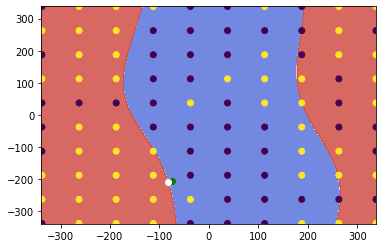

In [342]:
fig, ax = plt.subplots()
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(elec_x, elec_y, c=elec_target_plot)
ax.scatter(somax, somay, c='green')
#ax.scatter(bound_coords[:, 0], bound_coords[:, 1], c='black')
ax.scatter(somarx, somary, c='white')

In [319]:
bound_coords

array([], dtype=float64)

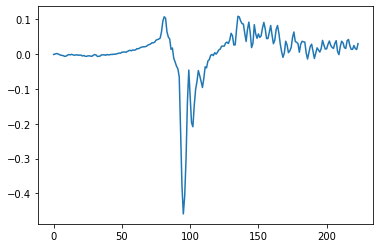

In [273]:
plt.plot(sort_temps[0].T[42])